# Generating Eeveelution Point Clouds With Point Set Generation Network
### Starter Project by Vadim Kudlay

This project is made in response to the following starter project option with some slight modifications: 

> **Generate your own dataset of 3D shapes and train a neural network to generate them.**
Skills demonstrated: 3D deep learning, data wrangling, 3D geometry
This is akin to the first project, but a bit more involved: instead of classifying two types of procedural shapes, you should write a procedure that generates just one type of procedural shape and then train a deep generative model to mimic the behavior of this procedural model. There are many possible 3D generative architectures you could go with: 3DCNNS, point set generating networks, or implicit field generators are good places to start.

I thought the previous project on making a PokéGAN was pretty fun, so I wanted to use a set of related Pokémon for the project. For those unfamiliar with Pokémon, Eevee is a normal-type Pokémon species introduced in the first generation of the franchise. It is famous for having a lot of evolutions, or "Eeveelutions," with different elemental types (i.e. Flareon is a fire type evolved up using a fire stone, Vaporeon is water, etc.). They are all pretty similar in design and can be considered a logical class both in body shape and otherwise. 

I have retrieved copies of the models used in Pokemon X/Y (Nintendo, 2013) and would like to create a network that can be trained to generate them. To do this, I use one of the approaches discussed in [Learning Representations and Generative Models for 3D Point Clouds (Achlioptas et al. 2018)](https://arxiv.org/pdf/1707.02392.pdf) for learning and generating point cloud representations of 3D models. This is mostly done because, honestly, it looked relatively simple and also because I couldn't get a good grasp of dealing with voxelized components in pyMesh to the extent as was necessary to replicate [the IM-NET implicit field decoder experiments](https://arxiv.org/abs/1812.02822).

I was slightly limited in the libraries I have access to since I am using an M1 Mac, but I was able to do just fine with TensorFlow 2.5 and pyMesh.

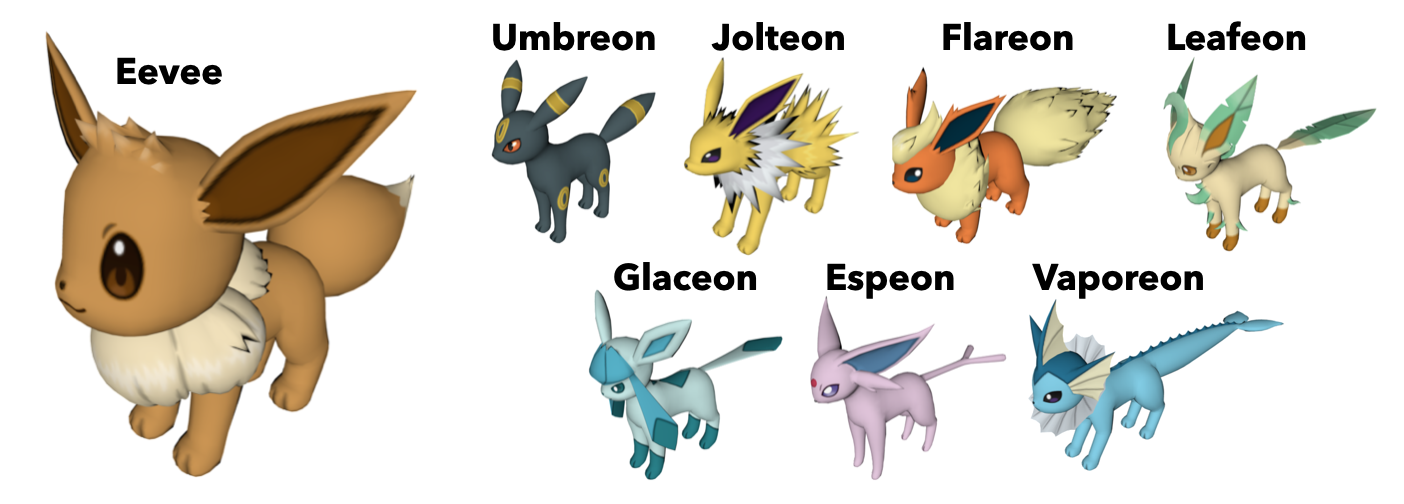

In [1]:
import sys
import os

import copy
import random 
from importlib import reload
from functools import partial
from collections import defaultdict

import numpy as np

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
import scipy
import random

import pymesh

import matplotlib as mpl
import matplotlib.pyplot as plt

print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pymesh {pymesh.version.__version__}")
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensorflow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:35:11) 
[Clang 11.1.0 ]
Pymesh 0.3
GPU is available


# Premise

For this project, we would like to create a generator that generates Eeveelutions. As such, we need to get some models for those. The models below have been sourced from [Models-Resource.com](https://www.models-resource.com/3ds/pokemonxy/) for non-commercial use and have been converted to non-textured OBJ files.

We have defined most of our utilities in auxiliary files so that we don't clutter up the notebook. Below is a quick demonstration of how to visualize some of the components that we will be interested in. The following also showcases barycentric sampling per a previous recommendation from Dr. Ritchie.

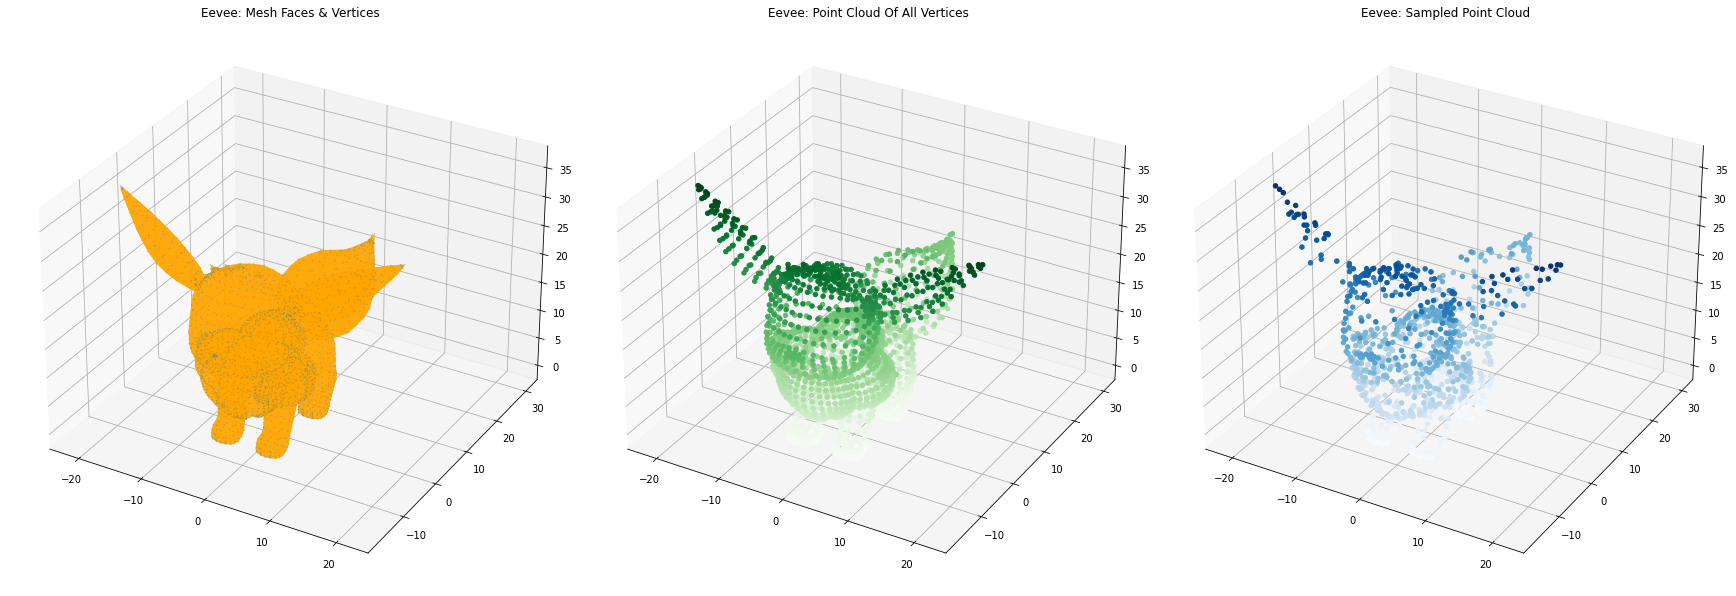

In [2]:
import utils.mesh_ops as mops

fig, axs = plt.subplots(1, 3, figsize=(24, 14), subplot_kw={'projection': '3d'}, constrained_layout=True)    

pic_dir = 'objs'
mesh = pymesh.load_mesh(f'{pic_dir}/Eevee.obj')

axs[0].set_title("Eevee: Mesh Faces & Vertices")
axs[1].set_title("Eevee: Point Cloud Of All Vertices")
axs[2].set_title("Eevee: Sampled Point Cloud")

mops.plot_mesh_verts(mesh, axs[0])
mops.plot_pointfield(mesh, axs[1])
mops.plot_pointfield(mops.sample_pointcloud(mesh, 2**10) , axs[2], cmap='Blues')

For our consideration, we are going to use the following models located in `/data/objs`. Some of these are Eeveelutions, and others are not. We are going to want a network that can actually do something outside of memorization and can generalize to other Pokémon, so we're going to use these Pokémon in a training set.

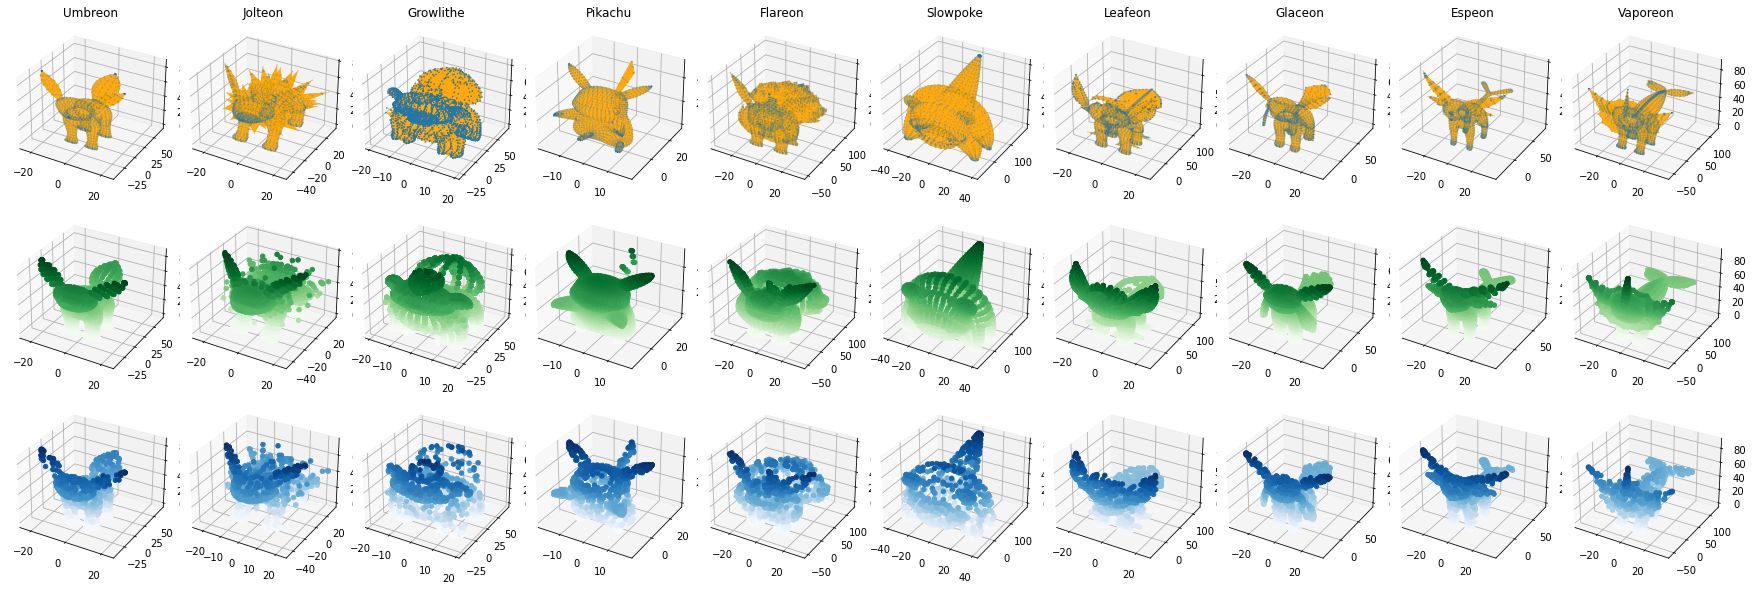

In [3]:
fig, axs = plt.subplots(3, 10, figsize=(24, 8), subplot_kw={'projection': '3d'}, constrained_layout=True)    
i = -1
for filename in os.listdir(pic_dir):
    if filename.lower().endswith(".obj") and filename != 'Eevee.obj': 
        i += 1
        fbase = filename.split(".")[0]
        axs[0][i].set_title(fbase)
        
        mesh = pymesh.load_mesh(f'{pic_dir}/{filename}')
        
        mops.plot_mesh_verts(mesh, axs[0][i])
        mops.plot_pointfield(mesh, axs[1][i])
        mops.plot_pointfield(mops.sample_pointcloud(mesh, 2**10) , axs[2][i], cmap='Blues')

In [4]:
raw_dict = {
    filename[:-4] : pymesh.load_mesh(f'{pic_dir}/{filename}')
        for filename in os.listdir(pic_dir) if filename.lower().endswith(".obj")
}

# valid_labs = random.sample(list(raw_dict.keys()), len(raw_dict)//3)
valid_labs = ['Pikachu', 'Slowpoke']
train_labs = [k for k in raw_dict.keys() if k not in valid_labs]

valid_dict = {k:v for k,v in raw_dict.items() if k in valid_labs}
train_dict = {k:v for k,v in raw_dict.items() if k in train_labs}
print("Train Labels:", train_labs)
print("Valid Labels:", valid_labs)

Train Labels: ['Umbreon', 'Jolteon', 'Eevee', 'Growlithe', 'Flareon', 'Leafeon', 'Glaceon', 'Espeon', 'Vaporeon']
Valid Labels: ['Pikachu', 'Slowpoke']


For them to be fed properly into a network, they will have to be augmented. Our `utils` module provides some easy data augmentation functions that can augment a point cloud to unit space, rotate it, and shrink it further if necessary. To start out with, we're going to only be using unit-space downscaling for our purposes, and will not need an inverse function (we can reason in the preprocessed space).

In [5]:
reload(mops)

def dataset_gen(mesh_dict, n_samples, n_clouds, batch_size, rotate, min_scale):
    '''Dataset Generator with augmentation and batching
    - mesh_dict  : dictionary of meshes to use
    - n_samples  : how many points per point cloud
    - n_clouds   : how many clouds per mesh
    - batch_size : how many clouds per batch 
    - rotate     : should clouds be rotated?
    - min_scale  : minimum down-scaling of mesh
    '''
    out = [[], []]  # input, labels
    for i, (k, v) in enumerate(mesh_dict.items()):
        out[0].extend(mops.augment_mesh(v, n_samples, n_clouds, rotate=rotate, min_scale=min_scale))
        out[1] += [k] * n_clouds

    buf_size = n_clouds * len(mesh_dict)
    seed = tf.random.uniform(shape=(), minval=0, maxval=1000, dtype=tf.int64)
    out[0] = tf.convert_to_tensor(out[0], dtype=tf.float32)
    out[0] = tf.data.Dataset.from_tensor_slices(out[0]).shuffle(buf_size, seed=seed).batch(batch_size)
    out[1] = tf.data.Dataset.from_tensor_slices(out[1]).shuffle(buf_size, seed=seed).batch(batch_size)
    return out

## Streamlined wrappers for our purposes

def valid_gen(n_samples, n_clouds, batch_size, rotate=False, min_scale=1):
    return dataset_gen(valid_dict, n_samples, n_clouds, batch_size, rotate, min_scale)
    
def train_gen(n_samples, n_clouds, batch_size, rotate=False, min_scale=1):
    return dataset_gen(train_dict, n_samples, n_clouds, batch_size, rotate, min_scale)

def all_gen(n_samples, n_clouds, batch_size, rotate=False, min_scale=1):
    return dataset_gen({**train_dict, **valid_dict}, n_samples, n_clouds, batch_size, rotate, min_scale)


Getting 3 batches of training data
 > 2 point clouds per mesh
 > Scaled to unit cube
 > Batch size of 3
 > Force break after 3rd batch

Metal device set to: Apple M1


2021-08-19 17:43:22.197215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-19 17:43:22.197301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


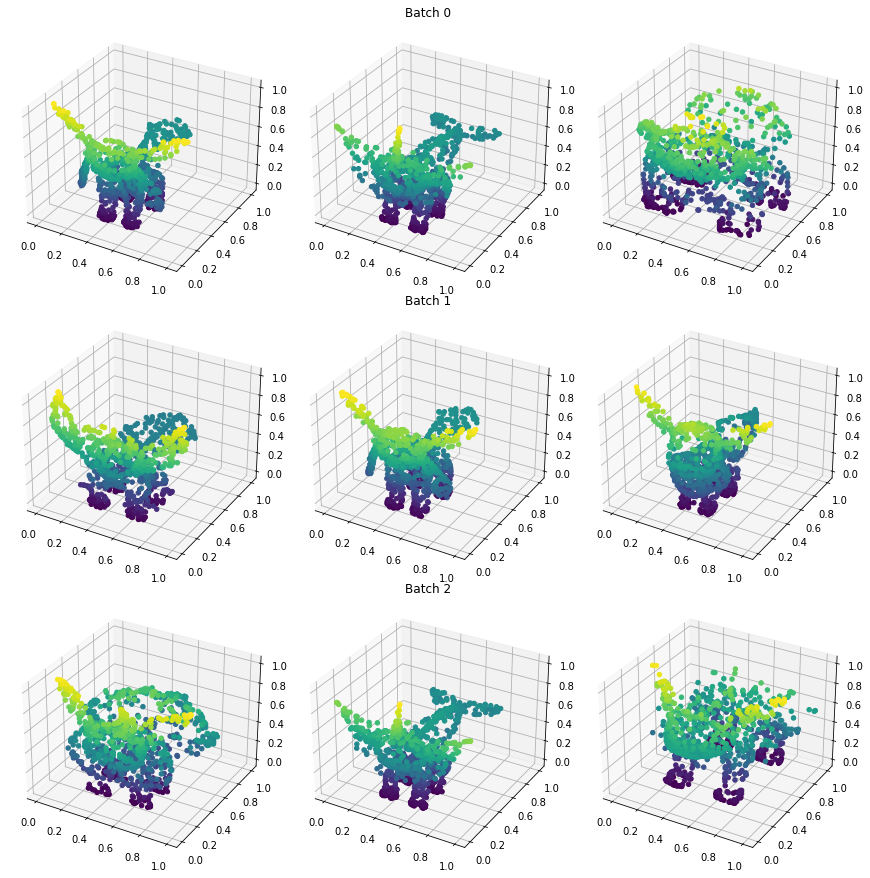

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, constrained_layout=True)    

print('''
Getting 3 batches of training data
 > 2 point clouds per mesh
 > Scaled to unit cube
 > Batch size of 3
 > Force break after 3rd batch
''')
for i, (batch_vals, batch_labs) in enumerate(zip(*train_gen(1024, 2, 3))):
    if i > 2: break
    axs[i][1].set_title(f'Batch {i}')
    for j, (val, lab) in enumerate(zip(batch_vals, batch_labs)):
        mops.plot_pointfield(val, axs[i][j], cmap='viridis')

## Defining The Network

Previously, I implemented a class for simple AEs, VAEs, and GANs. Now, we're going to modify the GAN class to conform to the SP-GAN architecture assumptions.

### Model Layers: 

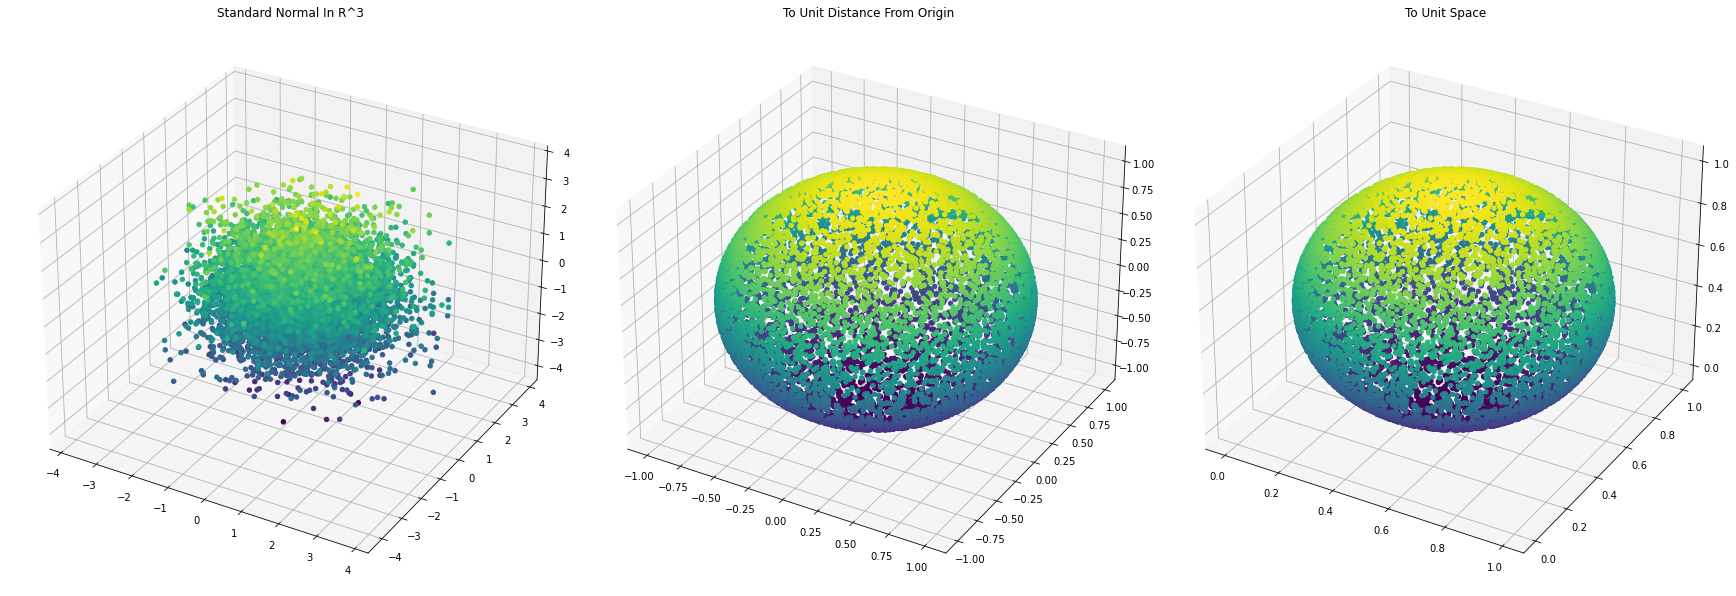

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(24, 14), subplot_kw={'projection': '3d'}, constrained_layout=True)    

axs[0].set_title(f'Standard Normal In R^3')
axs[1].set_title(f'To Unit Distance From Origin')
axs[2].set_title(f'To Unit Space')

temp = np.random.normal(0, 1, [10000,3])
mops.plot_pointfield(temp, axs[0], cmap='viridis')
temp /= np.linalg.norm(temp, axis=1, keepdims = True)
mops.plot_pointfield(temp, axs[1], cmap='viridis')
temp = (temp + 1)/2
mops.plot_pointfield(temp, axs[2], cmap='viridis')


We will also create a convenient visualization function to see the execution of the model while it is running. Don't worry if this looks out of place; it really just goes along with the respective model code in terms of structure, but I wanted it to be handled by the logging class and also wanted easy plotting re-specification in the notebook. 

## Running the Autoencoder

We have created an autoencoder specification in `cae.py`. We have also specified some loss functions to use, and log results in an auto-generated directory corresponding the the `StatusTracker` name. A rudementary checkpoint system is in place to where hopefully the model training can be resumed if something *unfortunate* happens. It's not bullet-proof, but I guess it's better than nothing...

The model specifications found in `AE_DefaultModel` reflect a best-effort attempt to replicate the structure in the paper. As you may have seen earlier, we will only be using 1024 point samples for our model instead of the recommended 2048. This is for the sake of compute time, since I would not like for these models to run for too long. The architecture has been compensated to reflect this (see `AE_DefaultModel` implementation).

The loss function used is based on Chamfer distance as specified in the paper (sources cited in code):
$$\mathcal{L}_{CH} = \sum_{x \in X}\min_{y \in h(X)}||x-y||^2_2 + \sum_{y \in h(X)}\min_{x \in X}||x-y||^2_2$$

In [8]:
from utils.status_tracker import StatusTracker

In [9]:
class SP_GAN:
    
    def __init__(self, 
        gen_model, dis_model, ball_gen, latz_gen,
        name = 'model', verbose=True
    ):
        '''Default constructor for Latent GAN'''
        self.verbose  = verbose
        self.model_name = name
        self.model_g, self.model_d = self.get_model(gen_model, dis_model)
        self.ball_gen = ball_gen
        self.latz_gen = latz_gen
        
        # Paper said to keep the ball consistent through training. Latz code varies
        np.random.seed(8675309)
        self.ball_code = self.ball_gen()
        self.get_gen_code = lambda: tf.expand_dims(tf.concat([self.ball_code, self.latz_gen()], axis=1), 0)
        
        self.loss_tracks = None
        self.loss_tracks_total = None

    def get_model(self, gen_model, dis_model):
        """Returns the generator and discriminator models"""
        model_g = gen_model(f'gen_model_{self.model_name}')
        if self.verbose: 
            print("Generator Structure:") 
            model_g.summary()
        model_d = dis_model(f'dis_model_{self.model_name}')
        if self.verbose: 
            print("Discriminator Structure:")
            model_d.summary()
        return model_g, model_d


    def gradient_penalty(self, f, real, fake, mode):
        """
        Gradient penalty function to conform to WGAN/DRAGAN standards
        From course content lab. Associated colab link:  
        https://colab.research.google.com/drive/1zAUGSNFENZ_iU7m8YkiniG8seUNqbYT5#scrollTo=gKNwOru-2_Vb
        """
        def _gradient_penalty(f, real, fake=None):
            def _interpolate(a, b=None):
                if b is None:   # interpolation in DRAGAN
                    beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                    b = a + 0.5 * tf.math.reduce_std(a) * beta
                shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
                alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
                inter = a + alpha * (b - a)
                inter.set_shape(a.shape)
                return inter

            x = _interpolate(real, fake)
            with tf.GradientTape() as t:
                t.watch(x)
                pred = f(x)
            grad = t.gradient(pred, x)
            norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
            gp = tf.reduce_mean((norm - 1.)**2)

            return gp
        
        if mode == 'dragan':
            return _gradient_penalty(f, real)
        elif mode == 'wgan-gp':
            return _gradient_penalty(f, real, fake)
        return tf.constant(0, dtype=real.dtype)


    def train(self, 
        train_set, epochs, optimizers, losses, test_samples, stat_tracker, gp_mode='none', gp_weight=0.5, train_counts=(1,1), load_cp=True
    ):
        """Training loop. Display generated images each epoch"""
        start_epoch = stat_tracker.load_cp([self.model_g, self.model_d], optimizers) if load_cp else 0

        loss_names = list(losses[0].keys()) + list(losses[1].keys())
        if gp_mode != 'none': loss_names += [gp_mode.upper()]
        
        self.loss_tracks = {k : tf.keras.metrics.Mean(name=k) for k in loss_names}
        self.loss_tracks_total = tf.keras.metrics.Mean(name='loss_total')

        stat_tracker.log(f"Begin Training Model '{self.model_name}'")

        for epoch in range(start_epoch, epochs+1):
            print(f'Start of epoch {epoch}', end='')
            train_ds = train_set() if hasattr(train_set, '__call__') else train_set

            stat_tracker.set_epoch_step(epoch, 0)
            stat_tracker.save_cp([self.model_g, self.model_d], ['gen', 'dis'], optimizers)

            # Iterate over the batches of the dataset.
            for step, inp in enumerate(train_ds[0]):

                if step % max(1, len(train_ds)//8) == 0: print('.', end='')
                stat_tracker.set_epoch_step(epoch, step)
                
                stat_tracker.log(f"Training Discriminator")
                for _ in range(train_counts[0]):
                    d_loss = 0
                    with tf.GradientTape() as d_tape:
                        self.model_g.trainable = False
                        self.model_d.trainable = True

                        ## Uber-dumb trial-and-error hack below. Don't like it.
                        true_inp = inp
                        fake_inp = tf.convert_to_tensor([self.model_g(self.get_gen_code())[0] for _ in inp])
                        
                        true_out = self.model_d(true_inp)
                        fake_out = self.model_d(fake_inp)
                                                
                        for name, lf in losses[0].items():
                            c_loss = lf(fake_out, true_out, self.model_d) / 2
                            self.loss_tracks[name](c_loss)
                            d_loss += c_loss
                            # print(f'{name}:', c_loss, end='\t')

                        if gp_mode != 'none':
                            gp = self.gradient_penalty(
                                partial(self.model_d, training=True), 
                                true_inp, fake_inp, 
                                mode=gp_mode
                            )
                            gp *= gp_weight / (len(inp) * 2)
                            self.loss_tracks[gp_mode.upper()](gp)
                            d_loss += gp
                            #print('gp:', gp, end='\t')
                            
                    grads = d_tape.gradient(d_loss, self.model_d.trainable_weights)
                    optimizers[0].apply_gradients(zip(grads, self.model_d.trainable_weights))

                stat_tracker.log(f"Training Generator")
                for _ in range(train_counts[1]):
                    g_loss = 0
                    with tf.GradientTape() as g_tape:
                        self.model_g.trainable = True
                        self.model_d.trainable = False
                        
                        fake_inp = tf.convert_to_tensor([self.model_g(self.get_gen_code())[0] for _ in inp])
                        fake_out = self.model_d(fake_inp)
                        hist['genl'] += [fake_inp, fake_out]
                        
                        for name, lf in losses[1].items():
                            c_loss = lf(fake_out, tf.ones_like(fake_out), self.model_g) / 2
                            self.loss_tracks[name](c_loss)
                            g_loss += c_loss
                            #print(f'{name}:', c_loss)

                    grads = g_tape.gradient(g_loss, self.model_g.trainable_weights)
                    optimizers[1].apply_gradients(zip(grads, self.model_g.trainable_weights))

                self.loss_tracks_total(g_loss + d_loss)

            mean_loss = self.loss_tracks_total.result().numpy()
            avg_losses = {k : v.result().numpy() for k,v in self.loss_tracks.items()}

            print(f'\nEpoch: {epoch} | mean loss = {mean_loss:.8f}', end='')
            losses_str = ' | '.join([f'{k} : {v:.5}' for k,v in avg_losses.items()])
            print(f'\t( {losses_str} )')
            stat_tracker.log(f"mean loss = {self.loss_tracks_total.result().numpy():.8f}\t( {losses_str} )")
            stat_tracker.write_loss(list(avg_losses.items()) + [('ALL', mean_loss)])

            stat_tracker.log(f"Starting Visualizations")
            stat_tracker.vis_save([self.model_g, self.model_d], test_samples, self.get_gen_code)
            stat_tracker.log(f" - Finished\n")
            
            self.loss_tracks_total.reset_state()
            [t.reset_state() for t in self.loss_tracks.values()]

In [10]:
import tensorflow as tf
from functools import partial
import tensorflow.keras.layers as tkl
import tensorflow.keras.backend as tkb
import tensorflow.keras as tk

def squared_dist(A, B):
    ## Compute batched pair-wise distance matrix
    # https://stackoverflow.com/a/51186660/5003309
    with tf.name_scope('square_dist'):
        row_norms_A = tf.reduce_sum(tf.square(A), axis=1)
        row_norms_A = tf.reshape(row_norms_A, [-1, 1])  # Column vector.

        row_norms_B = tf.reduce_sum(tf.square(B), axis=1)
        row_norms_B = tf.reshape(row_norms_B, [1, -1])  # Row vector.
        out = row_norms_A - 2 * tf.matmul(A, tf.transpose(B)) + row_norms_B
        
    return out


def get_edge_features(pc_k):
    '''Get edge features of point cloud using k neighbors'''
    pc, k = pc_k
    # Compute pairwise distance matrix and get KNN set
    dist_mat = tf.math.sqrt(squared_dist(pc[0], pc[0]))
    _, nn_idx = tf.math.top_k(-dist_mat, k=k)

    pc_ctr = tf.tile(pc, [1, 1, k])
    pc_ctr = tf.reshape(pc_ctr, pc.shape[1:-1] + [k] + pc.shape[-1])
    pc_ctr = tf.expand_dims(pc_ctr, 0)
    pc_nbr = tf.gather(pc, nn_idx, axis=1)

    out_sub = pc_nbr-pc_ctr
    out_cat = tf.concat([out_sub, pc_ctr], axis=3)
        
    return [out_sub, out_cat]
    
def AdaIN(F_Y):
    F, Y = F_Y
    F_mu = tf.math.reduce_mean(F, 1, name='get_mean')
    F_sg = tf.math.reduce_std(F, 1, name='ged_std')
    out = tf.math.divide(tf.math.subtract(F, F_mu), F_sg, name='ged_norm')
    out = tf.math.multiply(Y[0], out, name='normalize')
    out = tf.math.add(out, Y[1], name='offset')
    return out

def Dense_BN_LR(*args, **kwargs):
    return tk.Sequential(layers=[
        tkl.Dense(*args, **kwargs), tkl.BatchNormalization(), tkl.LeakyReLU()
    ])

class SP_GAN_DefaultModel:

    def __init__(self, n_samples, lp_dim=3, gp_dim=3):
        """LGAN_DefaultModel Default Constructor
        - n_samples  : number of point samples in the point clouds
        """
        self.n_samples = n_samples
        self.lp_dim = lp_dim
        self.gp_dim = gp_dim
        
    def uniform_unit_ball(self):
        '''
        Uniformly samples unit hyperball.
        http://corysimon.github.io/articles/uniformdistn-on-sphere/
        '''
        out = np.random.normal(0, 1, [self.n_samples, self.gp_dim])
        for i in range(self.n_samples):
            while np.linalg.norm(out[i]) < 0.0001: 
                # protecting against floating-point error
                out[i] = np.random.normal(0, 1, [self.n_samples, self.gp_dim])
        out /= np.linalg.norm(out, axis=1, keepdims = True)
        out = (out + 1)/2
        return out
    
    def normal_latent_code(self):
        '''Generates uniform latent code entries'''
        return tf.tile(
            np.random.normal(0, 1, [1, self.lp_dim]),
            [self.n_samples, 1]
        )

    def gen_model(self, name='gen_model'):
        """Defines the generator model with gen_layers layers"""
        inps = tkl.Input(shape=[self.n_samples, self.gp_dim + self.lp_dim])
        layers = self.gen_layers(inps)
        model = tk.Model(inps, layers, name=name)
        return model

    def dis_model(self, name='dis_model'):
        """Defines the critic model with dis_layers layers"""
        inps = tkl.Input(shape=[self.n_samples, 3])
        layers = self.dis_layers(inps)
        model = tk.Model(inps, layers, name=name)
        return model      
    
    def gen_layers(self, plm):
        k = 20
                        
        fe = tk.Sequential(name='fe_embedding', layers=[
            Dense_BN_LR( 32), 
            Dense_BN_LR( 64), 
        ])(plm)

        y1 = tk.Sequential(name='y1_embedding', layers=[
            Dense_BN_LR( 64),
        ])(fe)
        
        y2 = tk.Sequential(name='y2_embedding', layers=[
            Dense_BN_LR( 64),
            Dense_BN_LR(128),
        ])(fe)
        
        y1 = [Dense_BN_LR( 64)(y1), Dense_BN_LR( 64)(y1)]
        y2 = [Dense_BN_LR(128)(y2), Dense_BN_LR(128)(y2)]
        
        def GAM_AdaIN(k, out_depth, name):
            ## Graph-Attention Module + Adaptive-Instance Normalization
            def out_fn(inp, y):
            
                fg_sub, fg_cat = tkl.Lambda(get_edge_features, name=f'GAM/input_to_features_{name}')([inp, k])

                w = tk.Sequential(name=f'GAM/fg_sub_to_w_{name}', layers=[
                    tkl.Conv2D(3, 1), tkl.BatchNormalization(), tkl.LeakyReLU(),
                    tkl.Conv2D(3, 1), tkl.BatchNormalization(), tkl.LeakyReLU(), 
                    tkl.Softmax(axis=1)])(fg_sub)

                x = tk.Sequential(name=f'GAM/fg_cat_to_x_{name}', layers=[
                    tkl.Conv2DTranspose(3, 1), tkl.BatchNormalization(), tkl.LeakyReLU()])(fg_cat)

                fw = tkl.Lambda(lambda t: t[0]*t[1], name=f'GAM/xw_to_fw_{name}')([x, w])

                fg = tk.Sequential(name=f'GAM/fw_to_fg_{name}', layers=[
                    tkl.Conv2D(out_depth, [1, k], [1, 1]), tkl.BatchNormalization(), tkl.LeakyReLU(),
                    tkl.Reshape(fw.shape[1:-2] + [out_depth])
                ])(fw)

                return tkl.Lambda(AdaIN, name=f'GAM/fg_to_fa_{name}')([fg, y])
            
            return out_fn
        
        
        fa1 = GAM_AdaIN(k,  64, 1)(plm[:, :, :self.gp_dim], y1)
        fa2 = GAM_AdaIN(k, 128, 2)(fa1,                     y2)
        
        ## PointNet-esque finale
        x = tf.reduce_max(fa2, axis=1)
        x = tk.Sequential(name='PN-mlp', layers=[
            Dense_BN_LR(128),
            Dense_BN_LR(128),
        ])(x)
        x = tf.tile(x, [self.n_samples, 1])
        x = tf.expand_dims(x, 0)
        x = tf.concat([x, fa2], axis=2)
        x = tk.Sequential(name='final-mlp', layers=[
            Dense_BN_LR(128),
            Dense_BN_LR( 64),
            tkl.Dense(3, activation='sigmoid')
        ])(x)
                
        return x

    def dis_layers(self, inps):
        
        # feature extraction for both point- and shape-level prediction
        xf_base = tk.Sequential(layers=[
            Dense_BN_LR( 32),
            Dense_BN_LR( 64),
            Dense_BN_LR(128),
            Dense_BN_LR(256),
            Dense_BN_LR(self.n_samples)
        ])(inps)
        
        # point-level predictions
        x_point = tk.Sequential(layers=[
            Dense_BN_LR(256),
            Dense_BN_LR(128),
            Dense_BN_LR( 64),
            Dense_BN_LR( 32),
            Dense_BN_LR( 16),
            Dense_BN_LR(  8),
            tkl.Dense(1, activation='sigmoid')
        ])(xf_base)
        x_point = tf.reduce_mean(x_point)
        
        # point-level predictions
        xf_trans = tf.transpose(xf_base, perm=[0, 2, 1])
        x_shape = tk.Sequential(layers=[
            Dense_BN_LR(256),
            Dense_BN_LR(128),
            Dense_BN_LR( 64),
            Dense_BN_LR( 32),
            Dense_BN_LR( 16),
            tkl.Flatten(),
            Dense_BN_LR(8),
            tkl.Dense(1, activation='sigmoid')
        ])(xf_trans)
        
        # combining the predictions together
        xf = (x_shape + x_point)/2
                
        return xf


In [11]:
spgan_model_spec = SP_GAN_DefaultModel(2**10)
model_name = 'sp_gan_5'

# sp_gan_3 = using transpose in discriminator only
# sp_gan_4 = using transpose for shape-wise, normal for point-wise
# sp_gan_5 gets rid of non-eeveelutions, increases number of pcs per mesh per epoch

my_spgan = SP_GAN(
    gen_model = spgan_model_spec.gen_model,
    dis_model = spgan_model_spec.dis_model,
    ball_gen = spgan_model_spec.uniform_unit_ball, 
    latz_gen = spgan_model_spec.normal_latent_code,
    name = model_name
) 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Generator Structure:
Model: "gen_model_sp_gan_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 6)]    0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1024, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
GAM/input_to_features_1 (Lambda [(None, 1024, 20, 3) 0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
GAM/fg_cat_to_x_1 (Se

In [12]:
def ed(x): 
    """Shorthand for expanding dimensions to shape model inputs"""
    return tf.expand_dims(x, axis=0)

def vis_save_custom(models, test_samples, get_gen_code, epoch, step, out_path):
    """Helper function to plot some sample generated images"""
    gen, dis = models
    
#     from_train, from_valid = test_samples()
    
#     for i, (batch_vals, batch_labs) in enumerate(zip(*from_train)):
#         print(f'Batch {i}')
#         for j, (val, lab) in enumerate(zip(batch_vals, batch_labs)):
#             print(f' - lab: {lab}')

#     for i, (batch_vals, batch_labs) in enumerate(zip(*from_valid)):
#         print(f'Batch {i}')
#         for j, (val, lab) in enumerate(zip(batch_vals, batch_labs)):
#             print(f' - lab: {lab}')
    
    fig = plt.figure(figsize=(14, 4), constrained_layout=True)
    gs = fig.add_gridspec(2, 10)
    axs = [
        [fig.add_subplot(gs[:2, i:i+2], projection = '3d') for i in range(0, 10, 2)],
        #[fig.add_subplot(gs[2, i], projection = '3d') for i in range(8)],
        #[fig.add_subplot(gs[3, i], projection = '3d') for i in range(8)]
    ]
    [[ax.set(**{f'{d}lim3d':[0,1] for d in 'xyz'}) for ax in axc] for axc in axs]
    
    for i in range(3):
        gen_pc = gen(get_gen_code())[0]
        mops.plot_pointfield(gen_pc,  axs[0][i], cmap='viridis')

    for i in range(3, 4):
        mops.plot_pointfield(my_spgan.ball_code, axs[0][i], cmap='cool')
                
    for i in range(4, 5):
        gen_pc = gen(get_gen_code())[0]
        mops.plot_pointfield(gen_pc, axs[0][i], cmap='cool', c = [p[2] for p in my_spgan.ball_code])
    
    axs[0][0].set_title(f'Random Generations')
    axs[0][3].set_title(f'Relating to Unit Sphere')
    
#     mops.plot_pointfield(static_goal,  axs[0][0], cmap='viridis')
#     plot_pointfield(static_pred,  axs[0][1], cmap='viridis')
#     plot_pointfield(random_pred,  axs[0][2], cmap='magma')
#     plot_pointfield(augment_goal, axs[0][3], cmap='cividis', a=0.2)
#     plot_pointfield(augment_pred, axs[0][3], cmap='coolwarm')
#     axs[0][0].set_title(f'Static Sample Input: {static_glab}')
#     axs[0][1].set_title(f'Static Sample Output: {static_glab}')
#     axs[0][2].set_title(f'Random Uniform Z Output')
#     axs[0][3].set_title(f'Static Augmented Sample: {static_glab}')
    
#     for i,(verts, k) in enumerate(test_samples):
#         plot_pointfield(verts, axs[2][i], cmap='cool')
#         axs[2][i].set_title(k)
#         verts_pred = model(ed(verts))[0]
#         plot_pointfield(verts_pred, axs[1][i], cmap='winter')

    fig.suptitle(f'epoch: {epoch}')
    plt.savefig(f'{out_path}')
    plt.show()

Start of epoch 11.....
Epoch: 11 | mean loss = 0.50583953	( BCE_D : 0.24897 | BCE_G : 0.10673 | WGAN-GP : 0.15014 )
Start of epoch 12.....
Epoch: 12 | mean loss = 0.53111625	( BCE_D : 0.248 | BCE_G : 0.10683 | WGAN-GP : 0.17628 )
Start of epoch 13.....
Epoch: 13 | mean loss = 0.51357120	( BCE_D : 0.24607 | BCE_G : 0.10721 | WGAN-GP : 0.16029 )
Start of epoch 14.....
Epoch: 14 | mean loss = 0.46684763	( BCE_D : 0.24279 | BCE_G : 0.11234 | WGAN-GP : 0.11172 )
Start of epoch 15.....
Epoch: 15 | mean loss = 0.49796262	( BCE_D : 0.23548 | BCE_G : 0.12173 | WGAN-GP : 0.14076 )
Start of epoch 16.....
Epoch: 16 | mean loss = 0.49222803	( BCE_D : 0.22747 | BCE_G : 0.13272 | WGAN-GP : 0.13204 )
Start of epoch 17.....
Epoch: 17 | mean loss = 0.53011209	( BCE_D : 0.22513 | BCE_G : 0.13685 | WGAN-GP : 0.16813 )
Start of epoch 18.....
Epoch: 18 | mean loss = 0.50685948	( BCE_D : 0.22552 | BCE_G : 0.13533 | WGAN-GP : 0.14601 )
Start of epoch 19.....
Epoch: 19 | mean loss = 0.51364225	( BCE_D : 0.2359

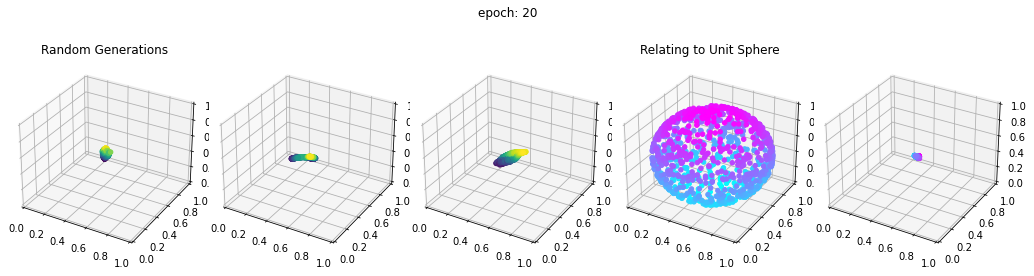

Start of epoch 21.....
Epoch: 21 | mean loss = 0.51285821	( BCE_D : 0.23191 | BCE_G : 0.1511 | WGAN-GP : 0.12985 )
Start of epoch 22.....
Epoch: 22 | mean loss = 0.47639820	( BCE_D : 0.22521 | BCE_G : 0.14895 | WGAN-GP : 0.10223 )
Start of epoch 23.....
Epoch: 23 | mean loss = 0.53201932	( BCE_D : 0.2198 | BCE_G : 0.14637 | WGAN-GP : 0.16585 )
Start of epoch 24.....
Epoch: 24 | mean loss = 0.54019254	( BCE_D : 0.24228 | BCE_G : 0.16246 | WGAN-GP : 0.13545 )
Start of epoch 25.....
Epoch: 25 | mean loss = 0.49801311	( BCE_D : 0.2378 | BCE_G : 0.1648 | WGAN-GP : 0.09541 )
Start of epoch 26.....
Epoch: 26 | mean loss = 0.49268103	( BCE_D : 0.2101 | BCE_G : 0.14667 | WGAN-GP : 0.13592 )
Start of epoch 27.....
Epoch: 27 | mean loss = 0.46677086	( BCE_D : 0.13519 | BCE_G : 0.19014 | WGAN-GP : 0.14144 )
Start of epoch 28.....
Epoch: 28 | mean loss = 0.45781514	( BCE_D : 0.11804 | BCE_G : 0.20373 | WGAN-GP : 0.13605 )
Start of epoch 29.....
Epoch: 29 | mean loss = 0.43968329	( BCE_D : 0.10408 |

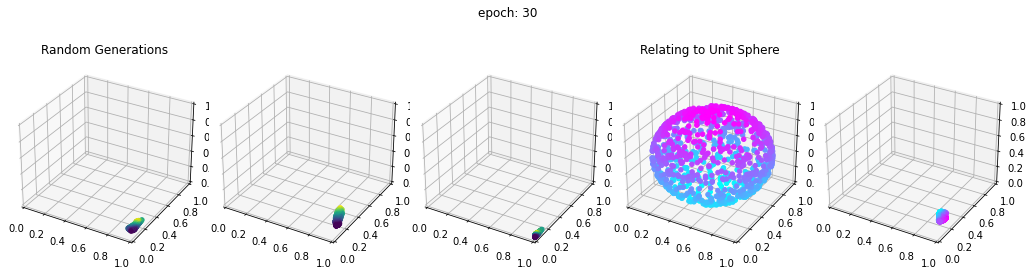

Start of epoch 31.....
Epoch: 31 | mean loss = 0.46448517	( BCE_D : 0.083449 | BCE_G : 0.23308 | WGAN-GP : 0.14796 )
Start of epoch 32.....
Epoch: 32 | mean loss = 0.48505679	( BCE_D : 0.076365 | BCE_G : 0.24041 | WGAN-GP : 0.16828 )
Start of epoch 33.....
Epoch: 33 | mean loss = 0.62483931	( BCE_D : 0.10441 | BCE_G : 0.23715 | WGAN-GP : 0.28328 )
Start of epoch 34.....
Epoch: 34 | mean loss = 0.53155828	( BCE_D : 0.10581 | BCE_G : 0.2365 | WGAN-GP : 0.18925 )
Start of epoch 35...

In [ ]:
from collections import defaultdict
hist = defaultdict(list)

def dis_loss(y_fake, y_true, D):
    """Discriminator (critic) loss
    - encourages true data predictions to tend towards 1
    - encourages fake data predictions to tend towards 0
    """
    hist['dis'] += [y_true, y_fake]
    return ((K.mean(y_true) - 1)**2 + K.mean(y_fake)**2)

def gen_loss(y_fake, y_goal, G):
    """Generator loss
    - encourages fake data predictions to tend towards 1
    """
    hist['gen'] += [y_fake, y_goal]
    if any(tf.math.is_nan(tf.reshape(y_fake, [-1]))):
        print('NAN alert in generator')
        return 1
    return (K.mean(y_fake) - 1)**2
    
my_spgan.train(
    train_set = partial(train_gen, n_samples = 1024, n_clouds = 5, batch_size = 10),
    epochs = 500,
    optimizers = [
        tf.keras.optimizers.Adam(learning_rate=0.0001),
        tf.keras.optimizers.Adam(learning_rate=0.0001),
    ],
    losses = [
        {'BCE_D' : dis_loss}, 
        {'BCE_G' : gen_loss}, 
    ],
    test_samples = lambda: [
        *valid_gen(n_samples=1024, n_clouds=1, batch_size=10), 
        *train_gen(n_samples=1024, n_clouds=1, batch_size=10)
    ],
    stat_tracker = StatusTracker(
        model_name, 
        vis_save_fn = vis_save_custom, 
        vis_interval = 10,
        checkpoint_interval = 1
    ),
    gp_mode = 'wgan-gp',
    gp_weight = 10,
    train_counts = (1, 1),
    load_cp = True
)